In [29]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [30]:

data = pd.read_csv('nyc_taxi.csv')
  
data_values = data.drop('timestamp',axis=1).values
  
data_values = data_values.astype('float32')
  
data_converted = pd.DataFrame(data_values,columns=data.columns[1:])
  
data_converted.insert(0, 'timestamp',data['timestamp'])

In [31]:
data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [32]:
data_converted = data_converted.dropna()

Anomaly Detection With Using Autoencoder

In [33]:

data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)
  
input_dim = data_converted.shape[1] - 1
encoding_dim = 10
  
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
  
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,batch_size=32, shuffle=True)
  
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
323/323 [==============================] - 0s 570us/step - loss: 33591720.0000
Epoch 2/50
323/323 [==============================] - 0s 542us/step - loss: 707.8079
Epoch 3/50
323/323 [==============================] - 0s 555us/step - loss: 0.0346
Epoch 4/50
323/323 [==============================] - 0s 596us/step - loss: 0.0345
Epoch 5/50
323/323 [==============================] - 0s 555us/step - loss: 0.0345
Epoch 6/50
323/323 [==============================] - 0s 587us/step - loss: 0.0345
Epoch 7/50
323/323 [==============================] - 0s 555us/step - loss: 0.0345
Epoch 8/50
323/323 [==============================] - 0s 554us/step - loss: 0.0345
Epoch 9/50
323/323 [==============================] - 0s 581us/step - loss: 0.0344
Epoch 10/50
323/323 [==============================] - 0s 579us/step - loss: 0.0344
Epoch 11/50
323/323 [==============================] - 0s 539us/step - loss: 0.0344
Epoch 12/50
323/323 [==============================] - 0s 551us/step - loss:

In [34]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [35]:
test = data_converted['value'].values
predictions = anomaly_scores.values
  
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


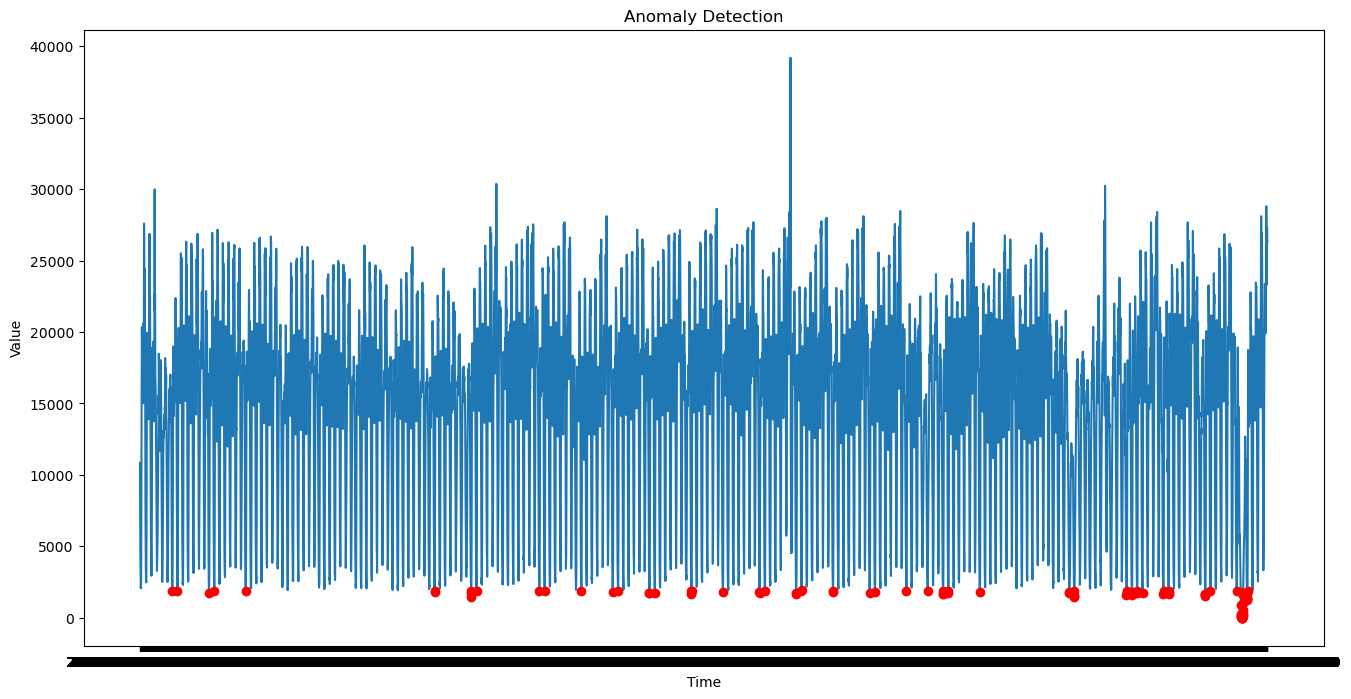

In [36]:

plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()